In [1]:
#importy
import numpy as np
import deepxde as dde
import matplotlib.pyplot as plt


2023-06-13 15:07:09.345689: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-13 15:07:13.928428: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-13 15:07:13.936611: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-13 15:07:24.378833: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Instructions for updating:
non-resource variables are not supported in the long term



In [2]:
#stale
L = 2

In [3]:
#dziedzina
geometry1 = dde.geometry.Hypercube(xmin=[-L/2, -L/2, 0.99, 0.99], xmax=[L/2, L/2, 1.01, 1.01])
geometry2 = dde.geometry.Hypercube(xmin=[-L/2, -L/2, 1.99, 1.99], xmax=[L/2, L/2, 2.01, 2.01])

geometry = dde.geometry.CSGUnion(geometry1, geometry2)

geometry1 = dde.geometry.Hypercube(xmin=[-L/2, -L/2, 0.99, 1.99], xmax=[L/2, L/2, 1.01, 2.01])
geometry2 = dde.geometry.Hypercube(xmin=[-L/2, -L/2, 1.99, 0.99], xmax=[L/2, L/2, 2.01, 1.01])

geometry = dde.geometry.CSGUnion(geometry, geometry1)
geometry = dde.geometry.CSGUnion(geometry, geometry2)






In [4]:
#funkcja
def pde(x, u):
    du_xx = dde.grad.hessian(u, x, i=0, j=0)
    du_yy = dde.grad.hessian(u, x, i=1, j=1)
    n1 = x[:, 2:3]
    n2 = x[:, 3:4]
    return (du_xx + du_yy)/2 + (n1**2 + n2**2) * np.pi**2 * u / (2 * L**2)

def solution(x):
    xi = x[:, 0:1]
    yi = x[:, 1:2]
    n1 = x[:, 2:3]
    n2 = x[:, 3:4]
    
    return 2/L * np.sin(n1*np.pi*(xi+L/2) / L) * np.sin(n2*np.pi*(yi+L/2) / L)



In [5]:
#warunki brzegowe

def boundaryFunction(x, on_boundary):
    if on_boundary and (dde.utils.isclose(abs(x[0]), L/2) or dde.utils.isclose(abs(x[1]), L/2)):
        return True
    return False



boundary_conditions = dde.icbc.DirichletBC(geometry, 
                                            lambda x: 0, 
                                            boundaryFunction
                                            )


In [6]:
#dane
data = dde.data.PDE(geometry, 
                    pde, 
                    boundary_conditions, 
                    num_domain=1200,
                    num_boundary=120,
                    num_test=1500
                    )

In [7]:
#siec
net = dde.nn.FNN([4]+[50]*3+[1],
                "tanh",
                "Glorot normal"
                )

In [8]:
#model
model = dde.Model(data, net)

model.compile("adam", lr=0.001)

Compiling model...
Building feed-forward neural network...


/home/filipjedrzejewski/.local/lib/python3.11/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'build' took 0.516166 s

'compile' took 1.345868 s



2023-06-13 15:07:54.562175: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled


Training model...

Step      Train loss              Test loss               Test metric
0         [2.49e+00, 4.89e-02]    [2.52e+00, 4.89e-02]    []  
500       [3.12e-04, 2.86e-05]    [2.64e-04, 2.86e-05]    []  
1000      [6.82e-05, 7.67e-06]    [5.90e-05, 7.67e-06]    []  
1500      [3.25e-05, 3.83e-06]    [2.87e-05, 3.83e-06]    []  
2000      [2.45e-05, 2.98e-06]    [2.11e-05, 2.98e-06]    []  
2500      [2.05e-05, 2.58e-06]    [1.74e-05, 2.58e-06]    []  
3000      [1.51e-05, 2.17e-06]    [1.28e-05, 2.17e-06]    []  
3500      [1.06e-05, 1.70e-06]    [8.97e-06, 1.70e-06]    []  
4000      [7.31e-06, 1.35e-06]    [6.31e-06, 1.35e-06]    []  
4500      [5.15e-06, 1.10e-06]    [4.54e-06, 1.10e-06]    []  
5000      [3.65e-05, 1.60e-06]    [3.60e-05, 1.60e-06]    []  

Best model at step 4500:
  train loss: 6.25e-06
  test loss: 5.64e-06
  test metric: []

'train' took 90.566670 s



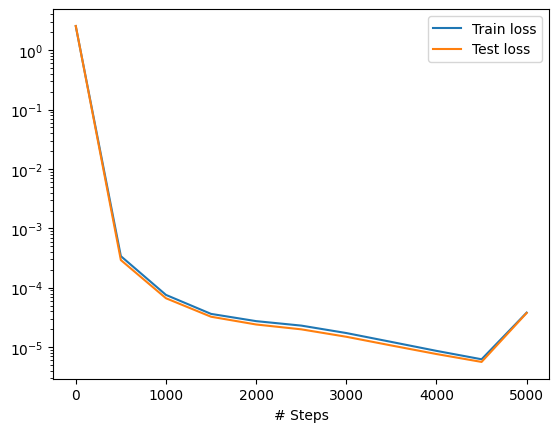

In [9]:
#trenowanie
loss_history, train_state = model.train(iterations = 5000, display_every=500)
dde.saveplot(loss_history, train_state, issave=False, isplot=True)


In [10]:
#testowanie
xData = np.linspace(-L/2, L/2, 1000)
yData = np.linspace(-L/2, L/2, 1000)
n1 = np.array([1 for i in range(1000)])
n2 = np.array([1 for i in range(1000)])

X = np.vstack((np.ravel(xData), np.ravel(yData), np.ravel(n1), np.ravel(n2))).T


y_pred = model.predict(X)

y_true = solution(X)




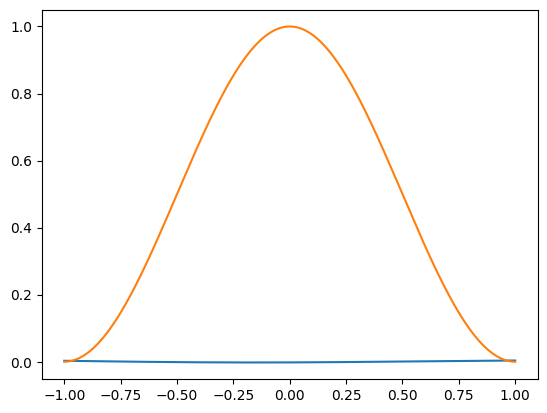

In [11]:
#wykresy
plt.plot(X[:, 0:1], y_pred)
plt.plot(X[:, 0:1], y_true)
plt.show()


